# Portfolio Optimization Project
Kripa Bansal\
Sophia Ford\
Natalia Ramirez

Constructing a portfolio with the best possible balance of risk (variance) and expected return (mean returns). 

## Data Cleaning

In [503]:
import sys
print(sys.executable)

/opt/anaconda3/bin/python


In [504]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

In [505]:
# Stocks we will use
tickers = ['KRE', 'DIS', 'GOOGL', 'NG=F']
#Final and start dates
end_date = datetime.today()
start_date = end_date - timedelta(days=10*365)
print(end_date)
print(start_date)

2024-05-09 18:35:29.102819
2014-05-12 18:35:29.102819


### Reading Data

In [506]:
# Initialize a list to hold the DataFrames
dataframes = []

for name in tickers:
    # Download stock data for given ticker between the start and end dates
    data = yf.download(name, start=start_date, end=end_date)
    
    # Add a new column for the ticker name
    data['Ticker'] = name
    
    # Append the DataFrame to the list
    dataframes.append(data)

stock_info = pd.concat(dataframes)

stock_info.reset_index(inplace=True)

print(stock_info)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

            Date       Open       High        Low      Close  Adj Close  \
0     2014-05-12  38.360001  39.040001  38.240002  38.939999  30.916559   
1     2014-05-13  38.959999  38.959999  38.430000  38.439999  30.519596   
2     2014-05-14  38.330002  38.360001  37.470001  37.580002  29.836800   
3     2014-05-15  37.380001  37.430000  36.590000  37.380001  29.678007   
4     2014-05-16  37.279999  37.380001  36.950001  37.299999  29.614485   
...          ...        ...        ...        ...        ...        ...   
10061 2024-05-02   1.931000   2.050000   1.927000   2.035000   2.035000   
10062 2024-05-03   2.031000   2.160000   2.012000   2.142000   2.142000   
10063 2024-05-06   2.170000   2.262000   2.133000   2.195000   2.195000   
10064 2024-05-07   2.206000   2.230000   2.142000   2.207000   2.207000   
10065 2024-05-08   2.219000   2.274000   2.167000   2.187000   2.187000   

        Volume Ticker  
0      4392200    KRE  
1      2702600    KRE  
2      3000100    KRE  
3  

In [507]:
print(stock_info['Date'])

0       2014-05-12
1       2014-05-13
2       2014-05-14
3       2014-05-15
4       2014-05-16
           ...    
10061   2024-05-02
10062   2024-05-03
10063   2024-05-06
10064   2024-05-07
10065   2024-05-08
Name: Date, Length: 10066, dtype: datetime64[ns]


## Plotting Adj. Close Price

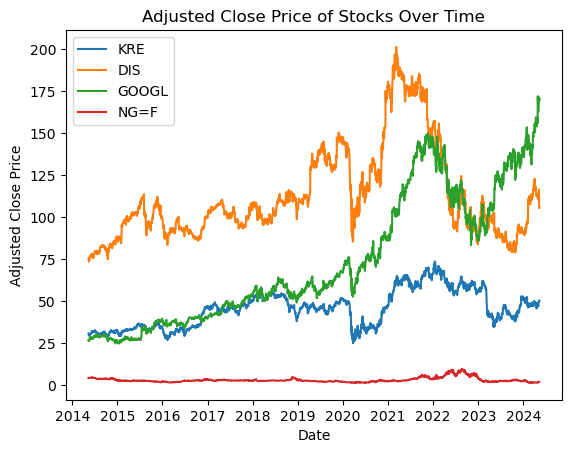

In [508]:
import matplotlib.pyplot as plt

# Create a plot to show closing price of each ticker
for ticker in stock_info['Ticker'].unique():
    subset = stock_info[stock_info['Ticker'] == ticker]
    plt.plot(subset['Date'], subset['Adj Close'], label=ticker)

plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Adjusted Close Price of Stocks Over Time')
plt.legend()

# Show the plot
plt.show()

## Daily Simple Return

In [509]:
returns = pd.DataFrame()

for ticker in stock_info['Ticker'].unique():
    subset = stock_info[stock_info['Ticker'] == ticker]
    ticker_change = subset.set_index('Date')['Adj Close'].pct_change()  # Keep the date index

    returns[ticker] = ticker_change  # This ensures the Date remains as the index

returns.dropna(how='all', inplace=True)

# Check the resulting DataFrame
print(returns.head())

                 KRE       DIS     GOOGL      NG=F
Date                                              
2014-05-13 -0.012840 -0.004125  0.005776 -0.017140
2014-05-14 -0.022372 -0.014133 -0.013166  0.002065
2014-05-15 -0.005322 -0.009515 -0.009899  0.023357
2014-05-16 -0.002140  0.002994 -0.001550 -0.012531
2014-05-19  0.016086  0.008210  0.019932  0.012916


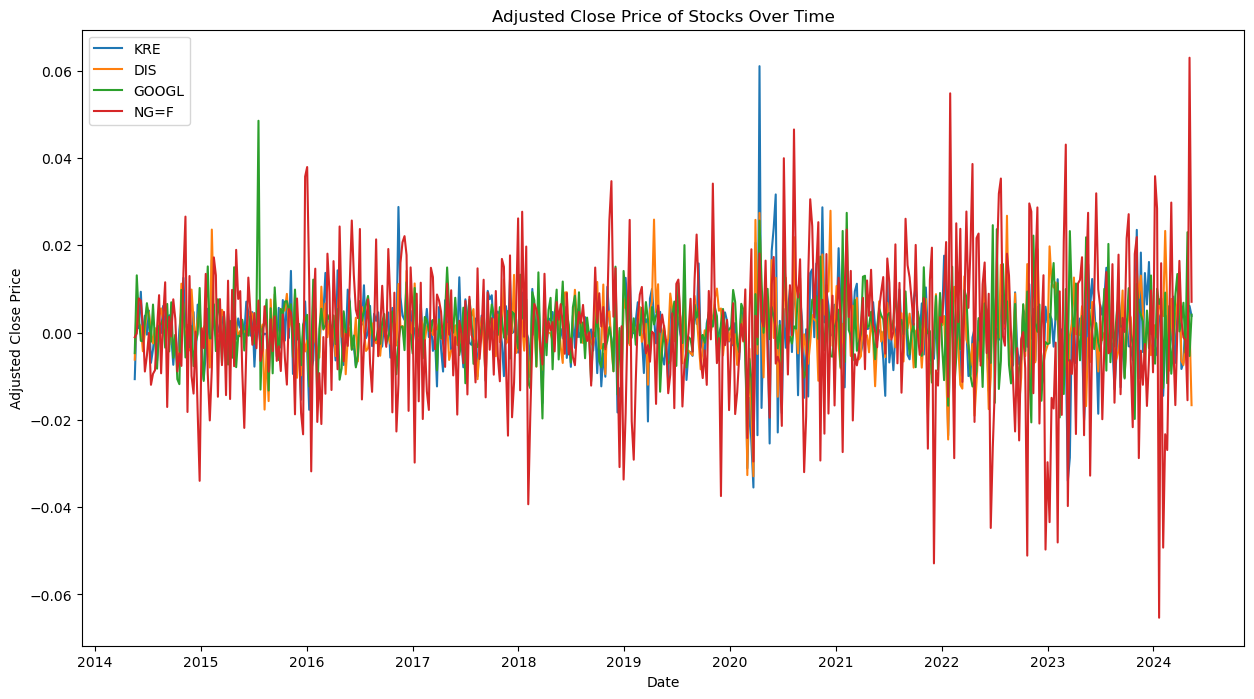

In [510]:
plt.figure(figsize=(15, 8))
weekly_returns = returns.resample('W').mean()
for ticker in returns.columns:
    plt.plot(weekly_returns.index, weekly_returns[ticker], label=ticker)

plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Adjusted Close Price of Stocks Over Time')
plt.legend()

plt.show()

## Creating Covariance Matrix

In [511]:
cov_matrix = returns.cov()
print(cov_matrix)

            KRE       DIS     GOOGL      NG=F
KRE    0.000378  0.000179  0.000129  0.000051
DIS    0.000179  0.000301  0.000133  0.000036
GOOGL  0.000129  0.000133  0.000314  0.000021
NG=F   0.000051  0.000036  0.000021  0.001467


### Mean Weights

In [512]:
mean_returns = returns.mean()
num_assets = len(returns.columns)

## Defining Metrics

Through mean, variance, and covariance we can formulate an optimization problem where you aim to minimize the portfolio's variance given expected returns or maximize the expected return for a given level of risk.\
**Formula:**
$\sigma^2_p = w^T \Sigma w$
### Efficient Frontier 
The set of optimal portfolios that offer the highest returns with a low level of risk or the lowest risk with the highest returns is known as the Efficient Frontier. 

In [513]:
 def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    # Weights must range from 0-1
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std_dev, returns

Mean returns helps in estimating the expected return of each asset and thus the return of the whole portfolio

## Optimizing Weights

Identifying the portfolio with less mean variance 

In [514]:
from scipy.optimize import minimize
def portfolio_variance(weights):
    return portfolio_performance(weights, mean_returns, cov_matrix)[0]

def portfolio_sharpe(weights):
    return -((portfolio_performance(weights, mean_returns, cov_matrix)[1] - risk_free_rate) / portfolio_performance(weights, mean_returns, cov_matrix)[0])

In [515]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Sum of weights must be 1
bounds = tuple((0,1) for asset in range(num_assets)) 
risk_free_rate = 0.0001#We would like a risk of 1%

In [516]:
# All stocks have the same weights at the start
initial_weights = np.array(num_assets * [1. / num_assets])

In [517]:
# Minimum variance
optimal_var_min = minimize(portfolio_variance, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Maximize Sharpe Ratio
optimal_sharpe = minimize(portfolio_sharpe, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

In [518]:
# Calculate unweighted returns using uniform weights
uniformly_weighted_returns = np.dot(returns, initial_weights.T)
unweighted_returns = returns.copy()
unweighted_returns['Unweighted_Returns'] = uniformly_weighted_returns
print(unweighted_returns.head())

                 KRE       DIS     GOOGL      NG=F  Unweighted_Returns
Date                                                                  
2014-05-13 -0.012840 -0.004125  0.005776 -0.017140           -0.007082
2014-05-14 -0.022372 -0.014133 -0.013166  0.002065           -0.011902
2014-05-15 -0.005322 -0.009515 -0.009899  0.023357           -0.000345
2014-05-16 -0.002140  0.002994 -0.001550 -0.012531           -0.003307
2014-05-19  0.016086  0.008210  0.019932  0.012916            0.014286


In [519]:
# Calculate optimized weighted returns
print('Optimal weights for minimum variance')
weights_min_var = optimal_var_min['x']
print(weights_min_var)
weighted_returns = np.dot(returns, weights_min_var.T)
returns['Weighted_Returns'] = weighted_returns 
returns.head()

Optimal weights for minimum variance
[0.19995124 0.3250818  0.36840642 0.10656055]


,KRE,DIS,GOOGL,NG=F,Weighted_Returns
Date,,,,,
2014-05-13,-0.012840,-0.004125,0.005776,-0.017140,-0.003607
2014-05-14,-0.022372,-0.014133,-0.013166,0.002065,-0.013698
2014-05-15,-0.005322,-0.009515,-0.009899,0.023357,-0.005315
2014-05-16,-0.002140,0.002994,-0.001550,-0.012531,-0.001361
2014-05-19,0.016086,0.008210,0.019932,0.012916,0.014605


## Create features

Using rolling weighted returns, the standard deviation of the weighted returns, and the previous returns. Along with the rolling closing prices in a window of 10 and 50 days. 

### Weighted Returns

In [520]:
returns['MA_10'] = returns['Weighted_Returns'].rolling(window=10).mean()
returns['STD_10'] = returns['Weighted_Returns'].rolling(window=10).std()
returns['Previous_Returns'] = returns['Weighted_Returns'].shift(1)
returns.head()

,KRE,DIS,GOOGL,NG=F,Weighted_Returns,MA_10,STD_10,Previous_Returns
Date,,,,,,,,
2014-05-13,-0.012840,-0.004125,0.005776,-0.017140,-0.003607,NaN,NaN,NaN
2014-05-14,-0.022372,-0.014133,-0.013166,0.002065,-0.013698,NaN,NaN,-0.003607
2014-05-15,-0.005322,-0.009515,-0.009899,0.023357,-0.005315,NaN,NaN,-0.013698
2014-05-16,-0.002140,0.002994,-0.001550,-0.012531,-0.001361,NaN,NaN,-0.005315
2014-05-19,0.016086,0.008210,0.019932,0.012916,0.014605,NaN,NaN,-0.001361


In [521]:
returns['MA_10'] = returns['Weighted_Returns'].rolling(window=10).mean()
# Volatility
returns['STD_10'] = returns['Weighted_Returns'].rolling(window=10).std()
returns['Previous_Returns'] = returns['Weighted_Returns'].shift(1)
returns = returns.dropna(subset=['MA_10', 'STD_10'])
returns.head()

,KRE,DIS,GOOGL,NG=F,Weighted_Returns,MA_10,STD_10,Previous_Returns
Date,,,,,,,,
2014-05-27,0.012061,0.005041,0.019635,0.022701,0.013703,0.002996,0.009356,0.011440
2014-05-28,-0.006995,-0.001672,-0.007689,0.025305,-0.002078,0.003149,0.009248,0.013703
2014-05-29,-0.000522,0.005144,0.000193,-0.012990,0.000255,0.004544,0.007264,-0.002078
2014-05-30,-0.000522,-0.000238,0.001910,-0.003729,0.000125,0.005088,0.006618,0.000255
2014-06-02,0.011491,0.003095,-0.012788,0.015412,0.000235,0.005248,0.006463,0.000125


### Unweighted Returns

In [522]:
unweighted_returns['MA_10'] = unweighted_returns['Unweighted_Returns'].rolling(window=10).mean()
unweighted_returns['STD_10'] = unweighted_returns['Unweighted_Returns'].rolling(window=10).std()
unweighted_returns['Previous_Returns'] = unweighted_returns['Unweighted_Returns'].shift(1)
unweighted_returns.head()

,KRE,DIS,GOOGL,NG=F,Unweighted_Returns,MA_10,STD_10,Previous_Returns
Date,,,,,,,,
2014-05-13,-0.012840,-0.004125,0.005776,-0.017140,-0.007082,NaN,NaN,NaN
2014-05-14,-0.022372,-0.014133,-0.013166,0.002065,-0.011902,NaN,NaN,-0.007082
2014-05-15,-0.005322,-0.009515,-0.009899,0.023357,-0.000345,NaN,NaN,-0.011902
2014-05-16,-0.002140,0.002994,-0.001550,-0.012531,-0.003307,NaN,NaN,-0.000345
2014-05-19,0.016086,0.008210,0.019932,0.012916,0.014286,NaN,NaN,-0.003307


In [523]:
unweighted_returns['MA_10'] = unweighted_returns['Unweighted_Returns'].rolling(window=10).mean()
unweighted_returns['STD_10'] = unweighted_returns['Unweighted_Returns'].rolling(window=10).std()
unweighted_returns['Previous_Returns'] = unweighted_returns['Unweighted_Returns'].shift(1)
unweighted_returns = unweighted_returns.dropna(subset=['MA_10', 'STD_10'])
unweighted_returns.head()

,KRE,DIS,GOOGL,NG=F,Unweighted_Returns,MA_10,STD_10,Previous_Returns
Date,,,,,,,,
2014-05-27,0.012061,0.005041,0.019635,0.022701,0.014859,0.002298,0.008969,0.010527
2014-05-28,-0.006995,-0.001672,-0.007689,0.025305,0.002237,0.003230,0.008348,0.014859
2014-05-29,-0.000522,0.005144,0.000193,-0.012990,-0.002044,0.004216,0.006802,0.002237
2014-05-30,-0.000522,-0.000238,0.001910,-0.003729,-0.000645,0.004186,0.006825,-0.002044
2014-06-02,0.011491,0.003095,-0.012788,0.015412,0.004302,0.004946,0.006301,-0.000645


### Original Stock DF Features

In [524]:
stock_info['Date'] = pd.to_datetime(stock_info['Date'])
# Set 'Date' as the index for both DataFrames.
stock_info.set_index('Date', inplace=True)
stock_info.head()

,Open,High,Low,Close,Adj Close,Volume,Ticker
Date,,,,,,,
2014-05-12,38.360001,39.040001,38.240002,38.939999,30.916559,4392200,KRE
2014-05-13,38.959999,38.959999,38.430000,38.439999,30.519596,2702600,KRE
2014-05-14,38.330002,38.360001,37.470001,37.580002,29.836800,3000100,KRE
2014-05-15,37.380001,37.430000,36.590000,37.380001,29.678007,5511100,KRE
2014-05-16,37.279999,37.380001,36.950001,37.299999,29.614485,2038200,KRE


In [525]:
stock_info['MA_10_close'] = stock_info.groupby('Ticker')['Adj Close'].transform(lambda x: x.rolling(window=10).mean())
stock_info['MA_50_close'] = stock_info.groupby('Ticker')['Adj Close'].transform(lambda x: x.rolling(window=50).mean())
stock_info = stock_info.dropna(subset=['MA_10_close', 'MA_50_close'])
stock_info.head()

,Open,High,Low,Close,Adj Close,Volume,Ticker,MA_10_close,MA_50_close
Date,,,,,,,,,
2014-07-22,38.939999,39.130001,38.570000,38.630001,30.797789,3055900,KRE,31.414855,31.332895
2014-07-23,38.630001,38.709999,38.389999,38.619999,30.789804,3834200,KRE,31.290483,31.330360
2014-07-24,38.790001,39.209999,38.720001,39.090000,31.164522,4025000,KRE,31.234675,31.343258
2014-07-25,38.900002,39.209999,38.799999,39.119999,31.188435,2141500,KRE,31.186042,31.370291
2014-07-28,39.200001,39.270000,38.520000,38.689999,30.845617,3850100,KRE,31.099939,31.393643


In [526]:
unweighted_merged_df = unweighted_returns.merge(stock_info[['MA_10_close', 'MA_50_close']], left_index=True, right_index=True, how='left')
unweighted_merged_df.dropna(subset=['MA_10_close', 'MA_50_close'], inplace=True)
unweighted_merged_df.head()

,KRE,DIS,GOOGL,NG=F,Unweighted_Returns,MA_10,STD_10,Previous_Returns,MA_10_close,MA_50_close
Date,,,,,,,,,,
2014-07-22,-0.004124,0.005482,0.008572,-0.020005,-0.002519,-0.002410,0.009836,-0.010441,31.414855,31.332895
2014-07-22,-0.004124,0.005482,0.008572,-0.020005,-0.002519,-0.002410,0.009836,-0.010441,79.075381,77.219449
2014-07-22,-0.004124,0.005482,0.008572,-0.020005,-0.002519,-0.002410,0.009836,-0.010441,29.579650,28.480870
2014-07-22,-0.004124,0.005482,0.008572,-0.020005,-0.002519,-0.002410,0.009836,-0.010441,4.032500,4.419340
2014-07-23,-0.000259,-0.001972,0.002684,-0.002651,-0.000550,-0.002899,0.009582,-0.002519,31.290483,31.330360


In [527]:
merged_df = returns.merge(stock_info[['MA_10_close', 'MA_50_close']], left_index=True, right_index=True, how='left')
merged_df.dropna(subset=['MA_10_close', 'MA_50_close'], inplace=True)
merged_df.head()

,KRE,DIS,GOOGL,NG=F,Weighted_Returns,MA_10,STD_10,Previous_Returns,MA_10_close,MA_50_close
Date,,,,,,,,,,
2014-07-22,-0.004124,0.005482,0.008572,-0.020005,0.001984,-0.000136,0.010225,-0.007898,31.414855,31.332895
2014-07-22,-0.004124,0.005482,0.008572,-0.020005,0.001984,-0.000136,0.010225,-0.007898,79.075381,77.219449
2014-07-22,-0.004124,0.005482,0.008572,-0.020005,0.001984,-0.000136,0.010225,-0.007898,29.579650,28.480870
2014-07-22,-0.004124,0.005482,0.008572,-0.020005,0.001984,-0.000136,0.010225,-0.007898,4.032500,4.419340
2014-07-23,-0.000259,-0.001972,0.002684,-0.002651,0.000013,-0.000900,0.009857,0.001984,31.290483,31.330360


## Splitting data

Past dates are used as the training set, while future dates (dates after training) are the test set.

### Weighted Returns

In [528]:
merged_df = merged_df.sort_index()
split_point = int(len(merged_df) * 0.7)

X_train = merged_df.iloc[:split_point].drop(['Weighted_Returns'], axis=1)
y_train = merged_df.iloc[:split_point]['Weighted_Returns']
X_test = merged_df.iloc[split_point:].drop(['Weighted_Returns'], axis=1)
y_test = merged_df.iloc[split_point:]['Weighted_Returns']
print(merged_df.iloc[split_point:])

                 KRE       DIS     GOOGL      NG=F  Weighted_Returns  \
Date                                                                   
2021-06-08 -0.000564 -0.003729 -0.001607  0.018893          0.000096   
2021-06-09 -0.016636 -0.001645  0.003961  0.000320         -0.002368   
2021-06-09 -0.016636 -0.001645  0.003961  0.000320         -0.002368   
2021-06-09 -0.016636 -0.001645  0.003961  0.000320         -0.002368   
2021-06-09 -0.016636 -0.001645  0.003961  0.000320         -0.002368   
...              ...       ...       ...       ...               ...   
2024-05-07 -0.003197 -0.095132  0.018739  0.005467         -0.024079   
2024-05-08  0.005814  0.000474 -0.010920 -0.009062         -0.003672   
2024-05-08  0.005814  0.000474 -0.010920 -0.009062         -0.003672   
2024-05-08  0.005814  0.000474 -0.010920 -0.009062         -0.003672   
2024-05-08  0.005814  0.000474 -0.010920 -0.009062         -0.003672   

               MA_10    STD_10  Previous_Returns  MA_10_close  

### Unweighted Returns

In [529]:
unweighted_merged_df = unweighted_merged_df.sort_index()
split_point = int(len(unweighted_merged_df) * 0.7)

X_train_uw = unweighted_merged_df.iloc[:split_point].drop(['Unweighted_Returns'], axis=1)
y_train_uw = unweighted_merged_df.iloc[:split_point]['Unweighted_Returns']
X_test_uw = unweighted_merged_df.iloc[split_point:].drop(['Unweighted_Returns'], axis=1)
y_test_uw = unweighted_merged_df.iloc[split_point:]['Unweighted_Returns']

In [530]:
print("Training data date range:")
print("Start date:", X_train.index.min())
print("End date:", X_train.index.max())

# Print the date range for the test data
print("Test data date range:")
print("Start date:", X_test.index.min())
print("End date:", X_test.index.max())

Training data date range:
Start date: 2014-07-22 00:00:00
End date: 2021-06-08 00:00:00
Test data date range:
Start date: 2021-06-08 00:00:00
End date: 2024-05-08 00:00:00


## Model Definition

In [531]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

param_grid = {
    'max_depth': [2, 3],
    'min_samples_split': [10,15,20,30],
    'max_features': [3, 5, 7],
    'n_estimators': [100, 200]
}

In [532]:
model_rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=1)
grid_search_rf.fit(X_train_uw, y_train_uw)
best_params = grid_search_rf.best_params_
best_score = grid_search_rf.best_score_

best_params, best_score

Fitting 5 folds for each of 48 candidates, totalling 240 fits


({'max_depth': 3,
  'max_features': 5,
  'min_samples_split': 30,
  'n_estimators': 200},
 -0.007992169365223258)

In [533]:
cross_val_rmse_tree = cross_val_score(grid_search_rf.best_estimator_, X_test_uw, y_test_uw, cv=5, scoring=make_scorer(mean_squared_error, squared=False))

print(f'RMSE of the stacking regressor on the test set: {cross_val_rmse_tree.mean()}')

RMSE of the stacking regressor on the test set: 0.008743931716407485


In [534]:
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
# Create the models for ensemble

model1_r = Pipeline([('model', SVR())])
model2_r = Pipeline([('model', DecisionTreeRegressor())])
model3_r = Pipeline([('model', KNeighborsRegressor())])

                 
## Create the ensemble
my_ensemble_r = VotingRegressor(estimators=[('svr', model1_r),('tree', model2_r),('knn', model3_r)])

params_r = {'svr__model__kernel': ['linear', 'rbf', 'poly'],
           'svr__model__C': [1, 10, 50, 100],
           'tree__model__max_depth': [2,3,4,5], 
           'knn__model__n_neighbors': [10,25,50,100]
           }

grid_r = GridSearchCV(my_ensemble_r, param_grid=params_r, cv=5, scoring = 'neg_root_mean_squared_error').fit(X_train_uw, y_train_uw)

cross_val_rmse = cross_val_score(grid_r.best_estimator_, X_train_uw, y_train_uw, cv=5, scoring=make_scorer(mean_squared_error, squared=False))


print(f'Best Ensemble: {cross_val_rmse.mean()}');

Best Ensemble: 0.01014260147219315


In [535]:
# Creating ensemble from the best Random Forest model
best_random_forest = grid_search_rf.best_estimator_

stacked_r = StackingRegressor(estimators=[('voting', grid_r.best_estimator_)], final_estimator=DecisionTreeRegressor(max_depth=3))
stacked_ensemble = stacked_r

ensemble_voting = VotingRegressor(estimators=[
    ('random_forest', best_random_forest),
    ('stacked', stacked_ensemble)
])
ensemble_voting.fit(X_train_uw, y_train_uw)

VotingRegressor(estimators=[('random_forest',
                             RandomForestRegressor(max_depth=3, max_features=5,
                                                   min_samples_split=30,
                                                   n_estimators=200,
                                                   random_state=42)),
                            ('stacked',
                             StackingRegressor(estimators=[('voting',
                                                            VotingRegressor(estimators=[('svr',
                                                                                         Pipeline(steps=[('model',
                                                                                                          SVR(C=10,
                                                                                                              kernel='linear'))])),
                                                                                        ('tree',
                                                                                         Pipeline(steps=[('model',
                                                                                                          DecisionTreeRegressor(max_depth=5))])),
                                                                                        ('knn',
                                                                                         Pipeline(steps=[('model',
                                                                                                          KNeighborsRegressor(n_neighbors=10))]))]))],
                                               final_estimator=DecisionTreeRegressor(max_depth=3)))])

### Weighted Predictions

In [536]:
ensemble_predictions = ensemble_voting.predict(X_test)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_predictions))
print(f'RMSE of the VotingRegressor ensemble on the test set: {ensemble_rmse}')

RMSE of the VotingRegressor ensemble on the test set: 0.010079023591054352


### Unweighted Predictions

In [537]:
ensemble_predictions_uw = ensemble_voting.predict(X_test_uw)
ensemble_rmse_uw = np.sqrt(mean_squared_error(y_test_uw, ensemble_predictions_uw))
print(f'RMSE of the VotingRegressor ensemble on the test set: {ensemble_rmse_uw}')

RMSE of the VotingRegressor ensemble on the test set: 0.010741045926411136


## Analyzing Predictions

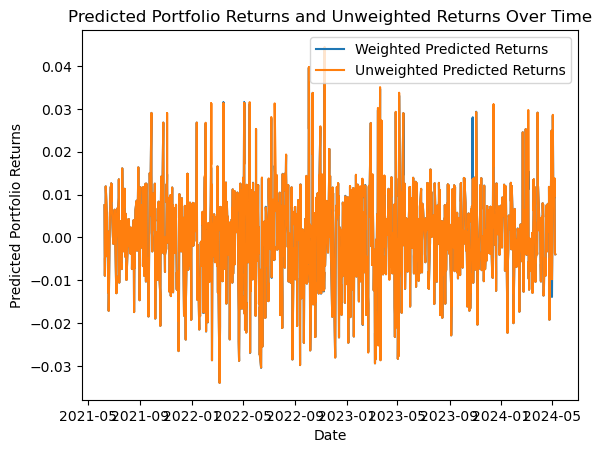

In [538]:
plt.plot(X_test.index, ensemble_predictions, label='Weighted Predicted Returns')
plt.plot(X_test_uw.index, ensemble_predictions_uw, label='Unweighted Predicted Returns')
# plt.plot(stock_returns.index, stock_returns['GOOGL'], label='Google Returns')
plt.xlabel('Date')
plt.ylabel('Predicted Portfolio Returns')
plt.title('Predicted Portfolio Returns and Unweighted Returns Over Time')
plt.legend()

plt.show()

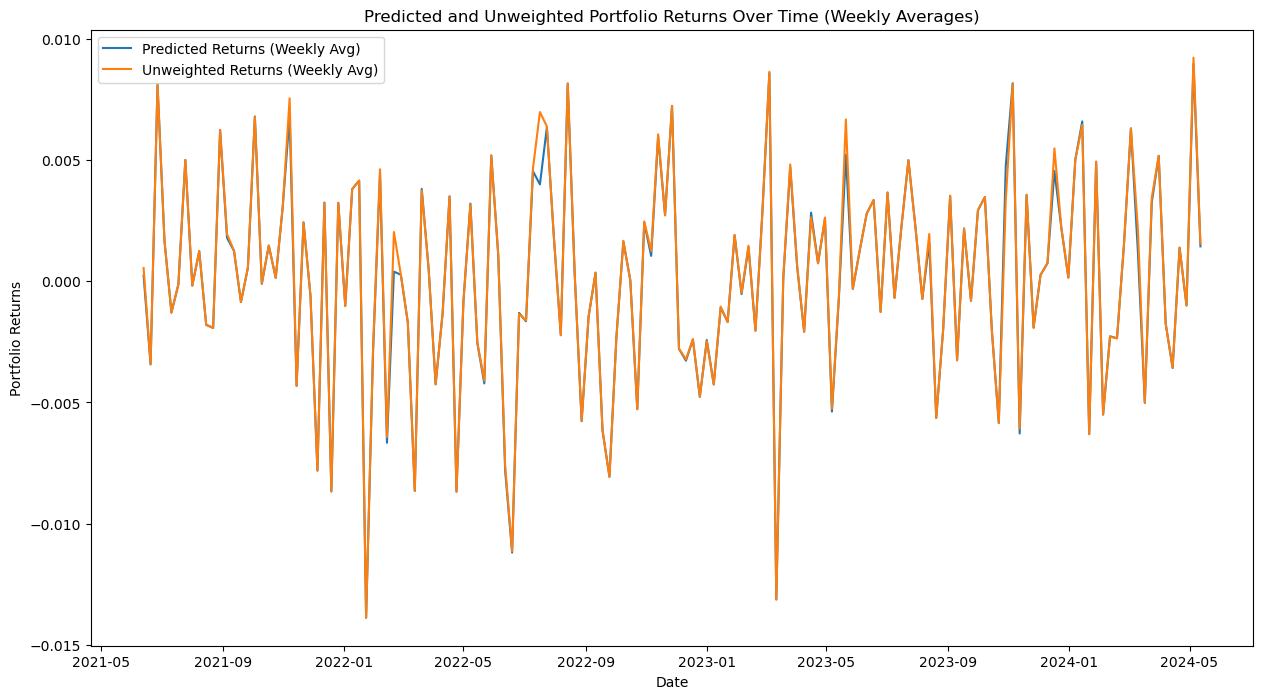

In [539]:
# Convert arrays to pandas Series (make sure `X_test.index` and `portfolio_df.index` are datetime indices)
predicted_returns_weighted = pd.Series(ensemble_predictions, index=X_test.index)
predicted_returns_unweighted = pd.Series(ensemble_predictions_uw, index=X_test_uw.index)

# Set the figure size
plt.figure(figsize=(15, 8))

# Resample the data to weekly averages
weekly_predicted_w = predicted_returns_weighted.resample('W').mean()
weekly_predicted_uw = predicted_returns_unweighted.resample('W').mean()

# Plot the resampled data
plt.plot(weekly_predicted_w.index, weekly_predicted_w, label='Predicted Returns (Weekly Avg)')
plt.plot(weekly_predicted_uw.index, weekly_predicted_uw, label='Unweighted Returns (Weekly Avg)')

# Labeling the axes and the plot
plt.xlabel('Date')
plt.ylabel('Portfolio Returns')
plt.title('Predicted and Unweighted Portfolio Returns Over Time (Weekly Averages)')
plt.legend()

# Show the plot
plt.show()

In [540]:
# Calculate the average predicted returns over the entire period
average_predicted_returns = weekly_predicted_w.std()

# Calculate the average unweighted returns over the entire period
average_unweighted_returns = weekly_predicted_uw.std()

print("Average Predicted Weighted Volatility over 3 years:", average_predicted_returns)
print("Average Predicted Unweighted Volatility over 3 years:", average_unweighted_returns)
print("Difference", average_unweighted_returns-average_predicted_returns)


Average Predicted Weighted Volatility over 3 years: 0.004299741211809066
Average Predicted Unweighted Volatility over 3 years: 0.0043461390607015165
Difference 4.639784889245036e-05


## Calculating Real Unweighted Returns

In [541]:
# Calculating Portfolio return before Optimizing
# Assign equal weights to each stock
weights = [1/4] * 4  # Four stocks, equal weight

stock_returns = merged_df[['KRE', 'DIS', 'GOOGL', 'NG=F']].iloc[split_point:]
portfolio_returns = stock_returns.dot(weights)
portfolio_df = pd.DataFrame({'Portfolio Returns': portfolio_returns})

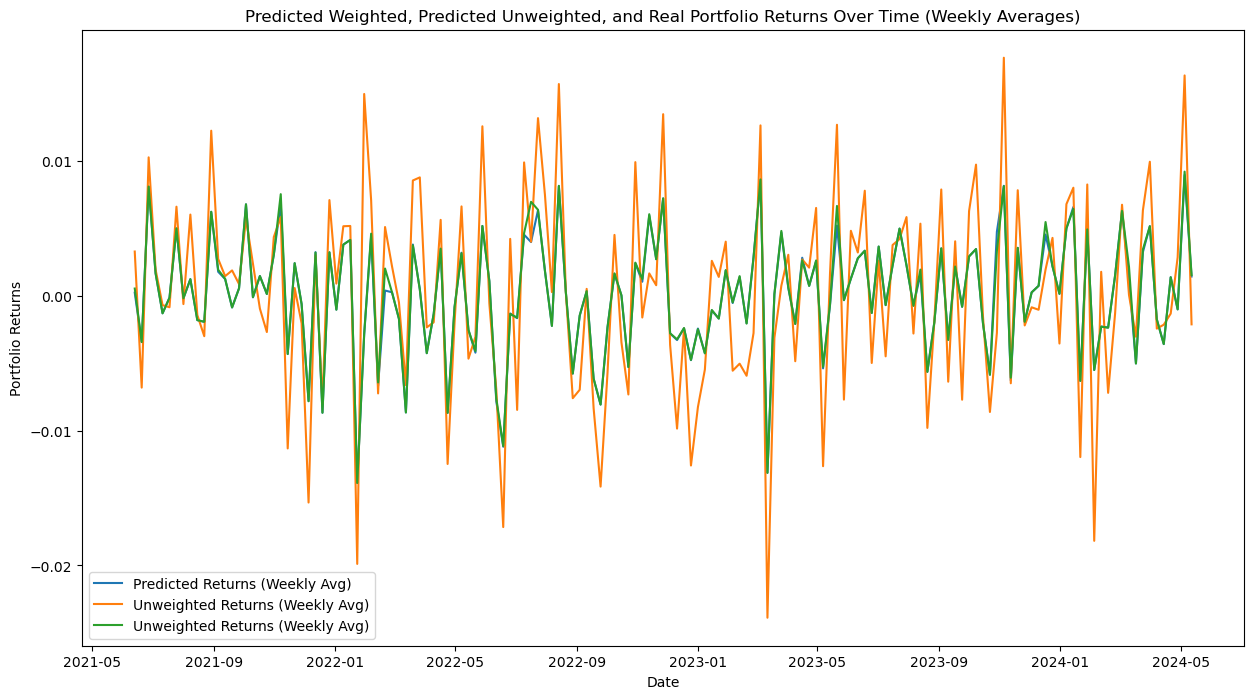

In [542]:
# Convert arrays to pandas Series (make sure `X_test.index` and `portfolio_df.index` are datetime indices)
predicted_returns_series = pd.Series(ensemble_predictions, index=X_test.index)
portfolio_returns_series = pd.Series(portfolio_df['Portfolio Returns'], index=portfolio_df.index)

# Set the figure size
plt.figure(figsize=(15, 8))

# Resample the data to weekly averages
weekly_predicted = predicted_returns_series.resample('W').mean()
weekly_unweighted = portfolio_returns_series.resample('W').mean()

# Plot the resampled data
plt.plot(weekly_predicted.index, weekly_predicted, label='Predicted Returns (Weekly Avg)')
plt.plot(weekly_unweighted.index, weekly_unweighted, label='Unweighted Returns (Weekly Avg)')
plt.plot(weekly_predicted_uw.index, weekly_predicted_uw, label='Unweighted Returns (Weekly Avg)')

# Labeling the axes and the plot
plt.xlabel('Date')
plt.ylabel('Portfolio Returns')
plt.title('Predicted Weighted, Predicted Unweighted, and Real Portfolio Returns Over Time (Weekly Averages)')
plt.legend()

# Show the plot
plt.show()